<a href="https://colab.research.google.com/github/neelabhro/Deep-Learning-based-Wireless-Communications/blob/main/Rayleigh_COLAB_NewCF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Import libraries

In [45]:
# magic command to use TF 1.X in colaboraty when importing tensorflow
%tensorflow_version 1.x 
import tensorflow as tf                       # imports the tensorflow library to the python kernel
tf.logging.set_verbosity(tf.logging.ERROR)    # sets the amount of debug information from TF (INFO, WARNING, ERROR)
import time
import random
print("Using tensorflow version:", tf.__version__)
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Using tensorflow version: 1.15.2


In [46]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import signal
import math
pi = tf.constant(math.pi)

#### System parameters

In [47]:
k = 8       # Number of information bits per message, i.e., M=2**k
n = 8       # Number of real channel uses per message
seed = 2    # Seed RNG reproduce identical results

[111, 321, 511, 765, 911, 1311, 1654, 1711, 1889, 1890, 1901, 2098, 2110, 2111, 2346, 2790, 3088, 3488, 3679, 4111, 4320, 4511, 4765, 4911, 5209, 5311, 5711, 5888, 5889, 5890, 5901, 6098, 6109, 6110, 6111, 6288, 6345, 6688, 6790, 7088, 7234, 7488, 7888, 8320, 8764, 9209, 9653, 9710, 9888, 9889]


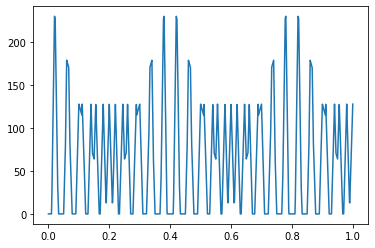

In [48]:
batch_size = 10000

#print(tr)
#plt.plot(t, tr)
T1 = random.randint(1, 10)
T2 = random.randint(1, 10)
M = 256
t = np.linspace(0, 1, batch_size)
triangle1 = signal.sawtooth(T1 * np.pi * 5 * t, 0.5)
triangle1 = M/2*(triangle1)
triangle1 = triangle1.clip(min=0)

triangle2 = signal.sawtooth(T2 * np.pi * 5 * t, 0.5)
triangle2 = M/2*(triangle2)
triangle2 = triangle2.clip(min=0)

triangle3 = triangle1 + triangle2
#triangle3 = triangle3/15*(7)
tr = triangle3
#tr = np.random.uniform(low=0, high=M-1, size=batch_size)
#bins = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
bins = np.arange(M-1)
tr = np.digitize(triangle3, bins, right=True)
plt.plot(t, triangle3)

#s_ind = np.empty(shape=(M,batch_size))
s_ind = {}
for j in range(M):
  s_ind[j] = [i for i, x in enumerate(tr) if x == j]
print(s_ind[15])

#### The Autoencoder Class
In order to quickly experiment with different architecture and parameter choices, it is useful to create a Python class that has functions for training and inference. Each autoencoder instance has its own Tensorflow session and graph. Thus, you can have multiple instances running at the same time without interference between them.

In [49]:
class AE(object):
    def __init__(self, k, n, seed=None, filename=None):
        assert (n%2 == 0), "Channel only allows complex symbols -> n must be a multiple of 2"
        self.k = k 
        self.n = n
        self.n_complex = int(self.n/2)
        self.bits_per_symbol = self.k/self.n_complex
        self.M = 2**self.k
        self.seed = seed if (seed is not None) else int(time.time())           
        self.graph = None
        self.sess = None   
        self.vars = None
        self.saver = None   
        self.constellations = None
        self.blers = None
        self.create_graph()
        self.create_session()
        if filename is not None:    
            self.load(filename)       
        return



    
    def create_graph(self):
        '''This function creates the computation graph of the autoencoder'''
        self.graph = tf.Graph()        
        with self.graph.as_default():    
            tf.set_random_seed(self.seed)
            batch_size = tf.placeholder(tf.int32, shape=())
            
            # Transmitter
            s = tf.random_uniform(shape=[batch_size], minval=0, maxval=self.M, dtype=tf.int64)
            #s = tf.random_uniform(shape=[1000], minval=0, maxval=self.M, dtype=tf.int64)
            

            #print(s)
            #plt.plot(t, s)
            #s = tf.convert_to_tensor(s, dtype=tf.int64)
            x = self.encoder(s)     
            
            # Channel
            noise_std = tf.placeholder(tf.float32, shape=())
            noise = tf.random_normal(tf.shape(x), mean=0.0, stddev=noise_std) 

            fade = tf.random.normal(shape=tf.shape(x))
            sparr1,sparr2 = tf.split(fade,num_or_size_splits=2, axis=2)
            complex_fade = tf.complex(sparr1, sparr2)
            fade = tf.abs(complex_fade)
            #fade = tf.math.sqrt(1/2)*fade

            #fade = 1
            y = tf.multiply(x,fade) + noise
            #y = x + noise
            #fade = 1            
           
            # Receiver
            s_hat = self.decoder(y)
            correct_s_hat = tf.argmax(tf.nn.softmax(s_hat), axis=1)

            sess = tf.Session()
            #print(sess.run((s_hat)))
            wt = list([1,2,3,4,5,6,7,8])
            wt = tf.convert_to_tensor(wt, dtype=tf.float32)
            #s_hat = (tf.math.multiply(s_hat,wt))
            
            print(sess.run((wt)))
            #print(sess.run((s_hat)))
            
            #for i in wt:
               #s_hat(i) = i*s_hat(i)
            print('See here')
            print(s_hat)
            print('See above')
            
            # Loss function
            #cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=s, logits=s_hat)
            #cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=s, logits=s_hat)
            #cross_entropy_0 = tf.losses.sparse_softmax_cross_entropy(labels=s, logits=s_hat)
            #weight = tf.math.pow(s+1, tf.constant(tf.cast(2, tf.int64)))
            #cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=s, logits=s_hat, weights=weight)
            #cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=s, logits=s_hat, weights= (256*(s+1)**(-1)))
            cost_func = []
            for i in range(M):
              #cost_func = tf.cast(cost_func, tf.float32) + (tf.cast(s_hat,tf.float32))*(((tf.cast(s,tf.float32))- (tf.cast(i,tf.float32)))**2)
              cost_func = (tf.cast(s_hat[:,i],tf.float32))*(((tf.cast(s,tf.float32))- (tf.cast(i,tf.float32)))**2)
            print(cost_func)
            #cross_entropy = tf.sqrt(tf.reduce_mean((tf.cast(s, tf.float64) - tf.cast(tf.argmax(tf.nn.softmax(s_hat), axis=1), tf.float64))**2))
            #cross_entropy = tf.keras.metrics.RootMeanSquaredError()
            #cross_entropy.update_state([s], [correct_s_hat])

            # Performance metrics

            correct_predictions = tf.equal(tf.argmax(tf.nn.softmax(s_hat), axis=1), s)
            accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
            bler = 1-accuracy

            #rmse = tf.sqrt(tf.reduce_mean((tf.cast(s,tf.float64) - tf.cast(correct_s_hat,tf.float64))**2))
            #rmse = tf.sqrt(tf.losses.mean_squared_error(tf.cast(s,tf.float64), tf.cast(correct_s_hat,tf.float64)))
            #cross_entropy = tf.compat.v1.losses.mean_squared_error(labels=tf.argmax(tf.nn.softmax(s_hat), axis=1), predictions = s, weights=1.0)
            #cross_entropy = tf.compat.v1.losses.hinge_loss(labels=s, logits=correct_s_hat)
            # Optimizer
            lr = tf.placeholder(tf.float32, shape=()) # We can feed in any desired learning rate for each step     
            #train_op = tf.train.AdamOptimizer(lr).minimize(cross_entropy)
            #train_op = tf.train.AdamOptimizer(lr).minimize(cross_entropy)
            train_op = tf.train.AdamOptimizer(lr).minimize(cost_func)
            #lr = tf.train.exponential_decay(1e-10, global_step=rmse, decay_steps=100, decay_rate=1.30)

        
            # References to graph variables we need to access later 
            self.vars = {
                'accuracy': accuracy,
                'batch_size': batch_size,
                'bler': bler,
                #'cross_entropy': cross_entropy,
                'cost_func': cost_func,
                'init': tf.global_variables_initializer(),
                'lr': lr,
                'noise_std': noise_std,
                'train_op': train_op,
                's': s,
                's_hat': s_hat,
                'correct_s_hat': correct_s_hat,
                'x': x,
            }            
            self.saver = tf.train.Saver()
        return
    
    def create_session(self):
        '''Create a session for the autoencoder instance with the compuational graph'''
        self.sess = tf.Session(graph=self.graph)        
        self.sess.run(self.vars['init'])
        return
    
    def encoder(self, input):
        '''The transmitter'''
        self.weight_var_rec = self.weight_variable((self.M,self.M)) # shape = (8,8)
        self.embedding_lookup_rec = tf.nn.embedding_lookup(self.weight_var_rec, input)
        print(self.embedding_lookup_rec)
        x = tf.nn.elu(self.embedding_lookup_rec)
        #x = tf.layers.dense(self.embedding_lookup_rec, self.M, activation=tf.nn.relu)
        x = tf.layers.dense(x, self.M, activation=None)
        x = tf.layers.dense(x, self.n, activation=None)
        #x = tf.layers.dense(x, self.n, activation=None)
        #x = tf.layers.dense(x, self.n, activation=None)
        #x = tf.layers.dense(x, self.n, activation=None)
        #x = tf.layers.dense(x, self.n, activation=None)
        x = tf.reshape(x, shape=[-1,self.n_complex,2])
        print(x);
        #Average power normalization
        x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x))) 
        return x
    
    def decoder(self, input):
        '''The Receiver'''
        #input = self.flip_decoder(input)
        y = tf.reshape(input, shape=[-1,self.n])
        y = tf.layers.dense(y, self.M, activation=None)
        y = tf.layers.dense(y, self.M, activation=None)
        y = tf.layers.dense(y, self.M, activation=None)
        #y = tf.layers.dense(y, self.M, activation=None)
        #y = tf.layers.dense(y, self.M, activation=None)
        #y = tf.layers.dense(y, self.M, activation=None)
        #y = tf.layers.dense(y, self.M, activation=None)
        #y = tf.layers.dense(y, self.M, activation=None)
        print(y);
        return y
    
    def EbNo2Sigma(self, ebnodb):
        '''Convert Eb/No in dB to noise standard deviation'''
        ebno = 10**(ebnodb/10)
        return 1/np.sqrt(2*self.bits_per_symbol*ebno)
    
    def gen_feed_dict(self, batch_size, ebnodb, lr):
        '''Generate a feed dictionary for training and validation'''        
        return {
            self.vars['batch_size']: batch_size,
            self.vars['noise_std']: self.EbNo2Sigma(ebnodb),
            self.vars['lr']: lr,
        }

    def gen_e2e_feed_dict(self, batch_size, ebnodb, s_input):
        '''Generate a feed dictionary for training and validation'''        
        return {
            self.vars['batch_size']: batch_size,
            self.vars['noise_std']: self.EbNo2Sigma(ebnodb),
            self.vars['s']: s_input,
        }   
    
    def load(self, filename):
        '''Load an pre_trained model'''
        return self.saver.restore(self.sess, filename)
        
    def plot_constellation(self, maxrange=None):
        '''Generate a plot of the current constellation'''
        x = self.transmit(range(self.M))
        if (maxrange is None):
            maxrange = np.max(np.abs(x))
        for k in range(self.n_complex):
            image = plt.figure(figsize=(6,6))
            plt.grid(True)
            plt.xlim(-maxrange,maxrange)
            plt.ylim(-maxrange,maxrange)
            for i in range(self.M):       
                plt.scatter(x[i,k,0],x[i,k,1],c="black",marker='x')   
            image.axes[0].set_xticks(np.array([-2,-1,0,1,2]))
            image.axes[0].set_yticks(np.array([-2,-1,0,1,2]))
            image.suptitle('%d. complex symbol' % (k+1))
            plt.xlabel('Re')
            plt.ylabel('Im')
        return x, image
    
    def save(self, filename):
        '''Save the current model'''
        return self.saver.save(self.sess, filename)  
    
    def test_step(self, batch_size, ebnodb):
        '''Compute the BLER over a single batch and Eb/No'''
        bler = self.sess.run(self.vars['bler'], feed_dict=self.gen_feed_dict(batch_size, ebnodb, lr=0))
        return bler
    
    def transmit(self, s):
        '''Returns the transmitted sigals corresponding to message indices'''
        return self.sess.run(self.vars['x'], feed_dict={self.vars['s']: s})

    def end2end(self, batch_size, ebnodb, input_s):
        '''Returns the transmitted sigals corresponding to message indices'''
        return self.sess.run(self.vars['correct_s_hat'], feed_dict=self.gen_e2e_feed_dict(batch_size, ebnodb, input_s)) 
        #print(self.sess.run(self.vars['correct_s_hat'], feed_dict={self.vars['s']: input_s}))     

    #print(self.sess.run(self.vars['s_hat'], feed_dict={self.vars['s']: s}))

    def train(self, training_params, validation_params):  
        #s_input = self.generate_distances(100,np.array([0, 1, 2, 3, 4, 5, 6]))
        
        '''Training and validation loop'''
        for index, params in enumerate(training_params):            
            batch_size, lr, ebnodb, iterations = params            
            print('\nBatch Size: ' + str(batch_size) +
                  ', Learning Rate: ' + str(lr) +
                  ', EbNodB: ' + str(ebnodb) +
                  ', Iterations: ' + str(iterations))
            
            val_size, val_ebnodb, val_steps = validation_params[index]
            
            for i in range(iterations):
                self.train_step(batch_size, ebnodb, lr)    
                if (i%val_steps==0):
                    #bler = self.sess.run(self.vars['bler'], feed_dict=self.gen_new_feed_dict(val_size, val_ebnodb, lr, s_input))
                    bler = self.sess.run(self.vars['bler'], feed_dict=self.gen_feed_dict(val_size, val_ebnodb, lr))
                    print(bler)                           
        return       
    
    def train_step(self, batch_size, ebnodb, lr):
        '''A single training step'''
        #self.sess.run(self.vars['train_op'], feed_dict=self.gen_new_feed_dict(batch_size, ebnodb, lr, s_input))
        self.sess.run(self.vars['train_op'], feed_dict=self.gen_feed_dict(batch_size, ebnodb, lr))
        return 
    
    def weight_variable(self, shape):
        '''Xavier-initialized weights optimized for ReLU Activations'''
        (fan_in, fan_out) = shape
        low = np.sqrt(6.0/(fan_in + fan_out)) 
        high = -np.sqrt(6.0/(fan_in + fan_out))
        return tf.Variable(tf.random_uniform(shape, minval=low, maxval=high, dtype=tf.float32))
    
    def bler_sim(self, ebnodbs, batch_size, iterations):
        '''Monte Carlo simulations of BLER for a range of Eb/No
           Sometimes we to compute statistics for batch sizes that do not fit into the GPUs memory.
           You can average over multiple batches with small size instead.           
        '''
        BLER = np.zeros_like(ebnodbs)
        for i in range(iterations):
            bler = np.array([self.sess.run(self.vars['bler'],
                            feed_dict=self.gen_feed_dict(batch_size, ebnodb, lr=0)) for ebnodb in ebnodbs])
            BLER = BLER + bler/iterations
        return BLER
    
    def plot_bler(self, EbNodB, BLER):
        '''Plot a BLER curve'''
        image = plt.figure(figsize=(10,8))
        plt.plot(EbNodB, BLER, '-r', linewidth=2.0)
        plt.yscale('log')
        plt.xlabel('EbNo (dB)', fontsize=18)
        plt.ylabel('Block-error rate', fontsize=18)
        plt.grid(True)
        plt.ylim([1e-5,1])
        return image

## Training parameters

In [50]:
train_EbNodB = 7
val_EbNodB = train_EbNodB

training_params = [
    #batch_size, lr, ebnodb, iterations
    [1000, 0.1, train_EbNodB, 10000]
]

validation_params = [
    #batch_size, ebnodb, val_steps 
    [100000, val_EbNodB, 1000],
    [100000, val_EbNodB, 1000],
    [100000, val_EbNodB, 1000]
]

## Create and train model

In [51]:
model_file_uw = 'models/ae_k_{}_n_{}'.format(k,n)
ae = AE(k,n,seed)
ae.train(training_params, validation_params)
ae.save(model_file_uw);
ae = AE(k,n,seed, filename=model_file_uw)

Tensor("embedding_lookup/Identity:0", shape=(?, 256), dtype=float32)
Tensor("Reshape:0", shape=(?, 4, 2), dtype=float32)
Tensor("dense_4/BiasAdd:0", shape=(?, 256), dtype=float32)
[1. 2. 3. 4. 5. 6. 7. 8.]
See here
Tensor("dense_4/BiasAdd:0", shape=(?, 256), dtype=float32)
See above
Tensor("mul_257:0", shape=(?,), dtype=float32)

Batch Size: 1000, Learning Rate: 0.1, EbNodB: 7, Iterations: 10000
0.9966
0.99615
0.99597
0.99577
0.99636
0.99562
0.99574
0.99567
0.99614
0.99616
Tensor("embedding_lookup/Identity:0", shape=(?, 256), dtype=float32)
Tensor("Reshape:0", shape=(?, 4, 2), dtype=float32)
Tensor("dense_4/BiasAdd:0", shape=(?, 256), dtype=float32)
[1. 2. 3. 4. 5. 6. 7. 8.]
See here
Tensor("dense_4/BiasAdd:0", shape=(?, 256), dtype=float32)
See above
Tensor("mul_257:0", shape=(?,), dtype=float32)


## Evaluate trained model

In [52]:
ae_uw = AE(k,n,seed, filename=model_file_uw) #Load a pretrained model that you have saved if needed

Tensor("embedding_lookup/Identity:0", shape=(?, 256), dtype=float32)
Tensor("Reshape:0", shape=(?, 4, 2), dtype=float32)
Tensor("dense_4/BiasAdd:0", shape=(?, 256), dtype=float32)
[1. 2. 3. 4. 5. 6. 7. 8.]
See here
Tensor("dense_4/BiasAdd:0", shape=(?, 256), dtype=float32)
See above
Tensor("mul_257:0", shape=(?,), dtype=float32)


### Plot of learned constellations

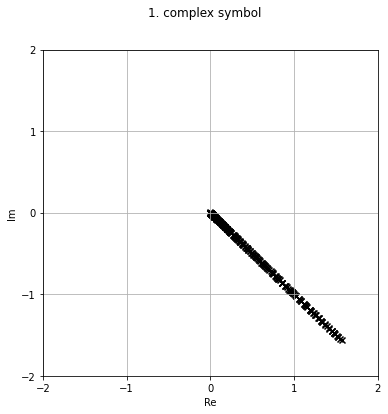

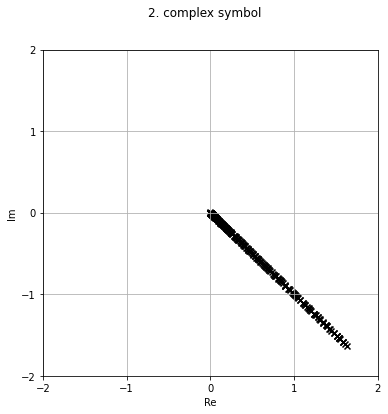

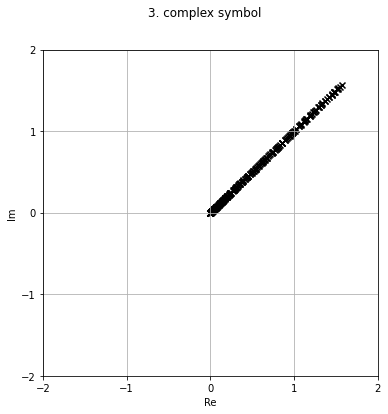

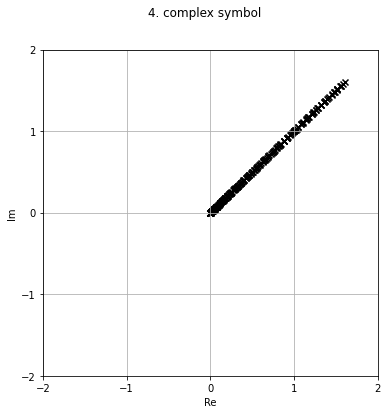

In [61]:
ae.plot_constellation();

(10000,)
(10000,)
[163 163 163 ... 163 163 163]
[ 5.0937502   5.08759634  4.38825718  3.97656153  3.68260984  3.45315712
  3.26448634  3.10394586  2.96398358  2.83972803  2.72785283  2.62598525
  2.53237319  2.44568594  2.36488898  2.28916207  2.21784386  2.15039328
  2.08636198  2.02537432  1.96711236  1.91130462  1.85771744  1.80614821
  1.7564201   1.70837786  1.66188439  1.61681802  1.57307027  1.53054397
  1.48915175  1.44881472  1.40946142  1.37102689  1.33345188  1.2966822
  1.26066815  1.22536399  1.19072758  1.15671992  1.1233049   1.09044898
  1.05812093  1.02629163  0.99493386  0.96402213  0.93353254  0.90344259
  0.87373112  0.84437815  0.81536481  0.78667324  0.75828648  0.73018845
  0.70236384  0.67479804  0.64747714  0.62038783  0.59351734  0.56685346
  0.54038443  0.51409895  0.48798613  0.46203546  0.43623677  0.41058021
  0.38505624  0.35965557  0.33436919  0.30918828  0.28410425  0.2591087
  0.23419339  0.20935023  0.18457128  0.1598487   0.13517478  0.11054187
  0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice.
  
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log


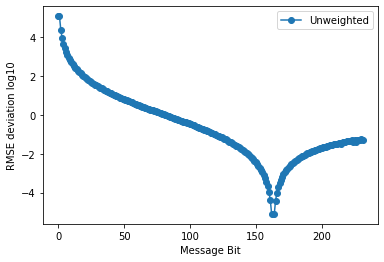

In [54]:
def rmse(predictions,targets):
  return (np.sqrt((np.subtract(predictions,targets) ** 2).mean()))   

tr_hat = ae.end2end(len(tr), 7, tr)
print(np.shape(tr))
print(np.shape(tr_hat))
print(tr_hat)


#tr_hat_w = ae_Weighted.end2end(len(tr), 7, tr)

rmse_uw = {}
for j in range(M):
  rmse_uw[j] = rmse(([tr_hat[x] for x in s_ind[j]]), ([tr[x] for x in s_ind[j]]))

#rmse_w = {}
#for j in range(M):
#  rmse_w[j] = rmse(([tr_hat_w[x] for x in s_ind[j]]), ([tr[x] for x in s_ind[j]]))



message_factor = (np.arange(M))
message_factor[0] = 1
rmse_uwA = []
for i in rmse_uw.values():
  rmse_uwA.append(i)

#rmse_wA = []
#for i in rmse_w.values():
#  rmse_wA.append(i)

    
#rmse_uw = [rmse_uw_0, rmse_uw_1, rmse_uw_2, rmse_uw_3, rmse_uw_4, rmse_uw_5, rmse_uw_6, rmse_uw_7, rmse_uw_8, rmse_uw_9, rmse_uw_10, rmse_uw_11, rmse_uw_12, rmse_uw_13, rmse_uw_14, rmse_uw_15]
rmse_uw = np.log(np.divide(rmse_uwA,message_factor))
#rmse_w = [rmse_w_0, rmse_w_1, rmse_w_2, rmse_w_3, rmse_w_4, rmse_w_5, rmse_w_6, rmse_w_7, rmse_w_8, rmse_w_9, rmse_w_10, rmse_w_11, rmse_w_12, rmse_w_13, rmse_w_14, rmse_w_15]
#rmse_w = np.log(np.divide(rmse_wA,message_factor))
#message = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
message = np.arange(M)

print(rmse_uw)
plt.plot(message, rmse_uw, '-o');
#plt.plot(message, rmse_w, '-*');
plt.xlabel('Message Bit')
plt.ylabel('RMSE deviation log10')
plt.legend(['Unweighted', 'Weighted(^2)'])


In [55]:
# 8-PSK Modulation
#8PSK constellation 
#Demodulation matrx
#Qfunction 

import numpy as np
from scipy import special
import matplotlib.pyplot as plt

import subprocess
import shlex


#Generating constellation points
s = np.zeros((8,2))
s_comp = np.zeros((8,1))+1j*np.zeros((8,1))
for i in range(8):
	s[i,:] = np.array(([np.cos(i*2*np.pi/8),np.sin(i*2*np.pi/8)])) #vector
	s_comp[i] = s[i,0]+1j*s[i,1] #equivalent complex number

#Generating demodulation matrix
A = np.zeros((8,2,2))
A[0,:,:] = np.array(([np.sqrt(2)-1,1],[np.sqrt(2)-1,-1]))
A[1,:,:] = np.array(([np.sqrt(2)+1,-1],[-(np.sqrt(2)-1),1]))
A[2,:,:] = np.array(([-(np.sqrt(2)+1),1],[np.sqrt(2)+1,1]))
A[3,:,:] = np.array(([np.sqrt(2)-1,1],[-(np.sqrt(2)+1),-1]))
A[4,:,:] = np.array(([-(np.sqrt(2)-1),-1],[-(np.sqrt(2)-1),1]))
A[5,:,:] = np.array(([-(np.sqrt(2)+1),1],[np.sqrt(2)-1,-1]))
A[6,:,:] = np.array(([np.sqrt(2)+1,-1],[-(np.sqrt(2)+1),-1]))
A[7,:,:] = np.array(([-(np.sqrt(2)-1),-1],[np.sqrt(2)+1,1]))

#Gray code
gray = np.zeros((8,3))
gray[0,:] = np.array(([0,0,0]))
gray[1,:] = np.array(([0,0,1]))
gray[2,:] = np.array(([0,1,1]))
gray[3,:] = np.array(([0,1,0]))
gray[4,:] = np.array(([1,1,0]))
gray[5,:] = np.array(([1,1,1]))
gray[6,:] = np.array(([1,0,1]))
gray[7,:] = np.array(([1,0,0]))


#Q-function
def qfunc(x):
	return 0.5*special.erfc(x/np.sqrt(2))

In [56]:
def decode(vec_comp):
	vec = np.zeros((2,1))
	vec[0] = np.real(vec_comp)
	vec[1] = np.imag(vec_comp)
	for i in range(8):
		y = A[i,:,:]@vec
		if (y [0] >= 0) and (y[1] >= 0):
			return s_comp[i]

#Extracting bits from demodulated symbols
def detect(vec_comp):
	vec = np.zeros((2,1))
	vec[0] = np.real(vec_comp)
	vec[1] = np.imag(vec_comp)
	for i in range(8):
		if s[i,0]==vec[0] and s[i,1] == vec[1]:
			return gray[i,:]

#Demodulating symbol stream from received noisy  symbols
def rx_symb(mat):
	len = mat.shape[1]
	rx_symb_stream = []
	for i in range(len):
		rx_symb_stream.append(decode(mat[:,i]))
	return rx_symb_stream

#Getting received bit stream from demodulated symbols
def rx_bit(mat):
	len = mat.shape[1]
	rx_bit_stream = []
	for i in range(len):
		rx_bit_stream.append(detect(mat[:,i]))
	return rx_bit_stream

In [57]:
#Generates a bitstream
def bitstream(n):
	return np.random.randint(0,2,n)

#Converts bits to 8-PSK symbols using gray code
def mapping(b0,b1,b2):
	if (b0 == 0 and b1 == 0 and b2 == 0):
		return s[0,:]
	elif (b0 == 0 and b1 == 0 and b2 == 1):
		return s[1,:]
	elif (b0 == 0 and b1 == 1 and b2 == 1):
		return s[2,:]
	elif (b0 == 0 and b1 == 1 and b2 == 0):
		return s[3,:]
	elif( b0 == 1 and b1 == 1 and b2 == 0):
		return s[4,:]
	elif(b0==1 and b1 == 1 and b2 == 1):
		return s[5,:]
	elif(b0==1 and b1 == 0 and b2 == 1):
		return s[6,:]
	elif(b0==1 and b1 == 0 and b2 == 0):
		return s[7,:]


#Converts bitstream to 8-PSK symbol stream
def symb(bits):
	symbol =[]
	i = 0
	while(1):
		try:
			symbol.append(mapping(bits[i],bits[i+1],bits[i+2]))
			i = i+3
		except IndexError:
			return symbol

#Converts bitstream to 8-PSK complex symbol stream
def CompSymb(bits):
	symbols_lst = symb(bits)
	symbols = np.array(symbols_lst).T #Symbol vectors
	symbols_comp = symbols[0,:]+1j*symbols[1,:] #Equivalent complex symbols
	return symbols_comp

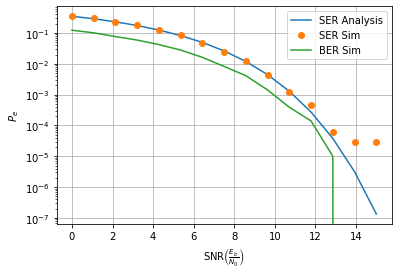

In [58]:

#SNR range
snrlen=15

#SNR in dB and actual per bit 
#(Check Proakis for factor of 6)
snr_db = np.linspace(0,snrlen,snrlen)
snr = 6*10**(0.1*snr_db)

#Bitstream size
bitsimlen = 99999

#Symbol stream size
simlen = bitsimlen //3

#Generating bitstream
bits = bitstream(bitsimlen)

#Converting bits to Gray coded 8-PSK symbols
#Intermediate steps  required for converting list to
#numpy matrix
symbols_lst = symb(bits)
symbols = np.array(symbols_lst).T #Symbol vectors
symbols_comp = symbols[0,:]+1j*symbols[1,:] #Equivalent complex symbols

ser =[]
ser_anal=[]
ber = []

#SNRloop
for k in range(0,snrlen):
	received = []
	t=0
	#Complex noise
	noise_comp = np.random.normal(0,1,simlen)+1j*np.random.normal(0,1,simlen)
	#Generating complex received symbols
  #fade_comp = np.random.normal(0,1,simlen)+1j*np.random.normal(0,1,simlen)
  #fade_comp = np.abs(fade_comp)
  #fade_comp = np.math.sqrt(1/2)*fade_comp
	y_comp = np.sqrt(snr[k])*symbols_comp +noise_comp
	brx = []
	for i in range(simlen):
		srx_comp = decode(y_comp[i]) #Received Symbol
		brx.append(detect(srx_comp))  #Received Bits
		if symbols_comp[i]==srx_comp:
			t+=1; #Counting symbol errors
	#Evaluating SER
	ser.append(1-(t/33334.0))
	ser_anal.append(2*qfunc((np.sqrt(snr[k]))*np.sin(np.pi/8)))
	#Received bitstream
	brx=np.array(brx).flatten()
	#Evaluating BER
	bit_diff = bits-brx
	ber.append(1-len(np.where(bit_diff == 0)[0])/bitsimlen)



#Plots
plt.semilogy(snr_db,ser_anal,label='SER Analysis')
plt.semilogy(snr_db,ser,'o',label='SER Sim')
plt.semilogy(snr_db,ber,label='BER Sim')
plt.xlabel('SNR$\\left(\\frac{E_b}{N_0}\\right)$')
plt.ylabel('$P_e$')
plt.legend()
plt.grid()

### BLER Simulations

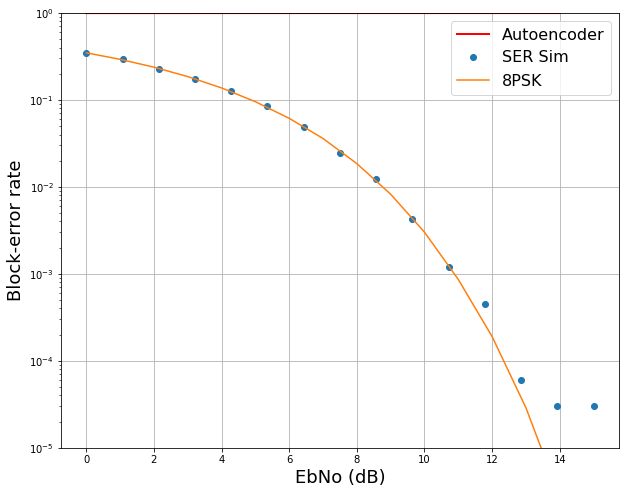

In [59]:
 ebnodbs = np.linspace(0,14,15)
BLER_8PSK = [0.3478959, 0.2926128, 0.2378847, 0.1854187, 0.1372344, 0.0953536, 0.0614003, 0.0360195, 0.0185215, 0.0082433, 0.0030178, 0.0008626, 0.0001903, 0.0000289, 0.0000027, ]
blers = ae.bler_sim(ebnodbs, 1000000, 1);
ae.plot_bler(ebnodbs, blers);
plt.semilogy(snr_db,ser,'o')
plt.plot(ebnodbs,BLER_8PSK);
plt.legend(['Autoencoder', 'SER Sim', '8PSK'], prop={'size': 16}, loc='upper right');